# Filtering of OFDM signals

Install dependencies

In [1]:
!pip install numpy matplotlib scipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, firwin, filtfilt, butter, lfilter, freqz

from calculate_evm import calculate_evm
from calculate_magnitude import calculate_magnitude
from calculate_phase import calculate_phase

Calculate modulation symbols (256QAM)

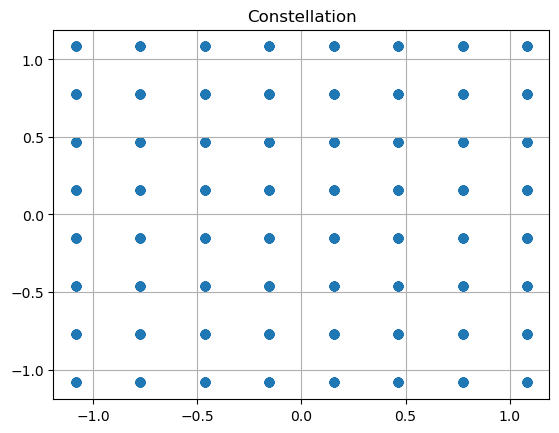

In [3]:
number_of_symbols = 2048
np.random.seed(42)
symbol_re = np.random.randint(0, 8, number_of_symbols) * 2 - 7 
symbol_im = np.random.randint(0, 8, number_of_symbols) * 2 - 7 
symbols = symbol_re + 1.0j * symbol_im
symbols = symbols / np.sqrt(np.mean(np.abs(symbols) ** 2)) 
plt.figure()
plt.grid()
plt.scatter(np.real(symbols), np.imag(symbols))
plt.title("Constellation")
plt.show()

Generate OFDM signal (ignoring CP)

In [4]:
ofdm = np.fft.ifft(symbols)

Perform digital upconversion to carrier frequency

In [5]:
subcarrier_spacing = 15e3
fs_bb = number_of_symbols * subcarrier_spacing
interpolation_factor = 164
fs = fs_bb * interpolation_factor
fc = fs / 2.5
interpolation_factor = fs / fs_bb
print(f"number of symbols = {number_of_symbols}, "
      f"subcarrier spacing = {subcarrier_spacing / 1e3}kHz, "
      f"sampling frequency (baseband) = {fs_bb / 1e6:.2f}MHz, "
      f"carrier frequency = {fc / 1e9:.2f}GHz, "
      f"sampling frequency (carrier) = {fs / 1e9:.2f}GHz, "
      f"interpolation factor = {interpolation_factor}")
upsampled_ofdm = resample(ofdm, int(len(ofdm) * interpolation_factor))
print(f"number of samples before upsampling: {len(ofdm)}, "
      f"number of samples after upsampling: {len(upsampled_ofdm)}")
t = np.arange(len(upsampled_ofdm)) / fs
carrier_signal = np.exp(1.0j * 2 * np.pi * fc * t)
upconverted_signal = np.real(upsampled_ofdm * carrier_signal)

number of symbols = 2048, subcarrier spacing = 15.0kHz, sampling frequency (baseband) = 30.72MHz, carrier frequency = 2.02GHz, sampling frequency (carrier) = 5.04GHz, interpolation factor = 164.0
number of samples before upsampling: 2048, number of samples after upsampling: 335872


Add some dummy filtering using zero-phase filter / IIR filter. Then, plot frequency and phase response of the used filter.

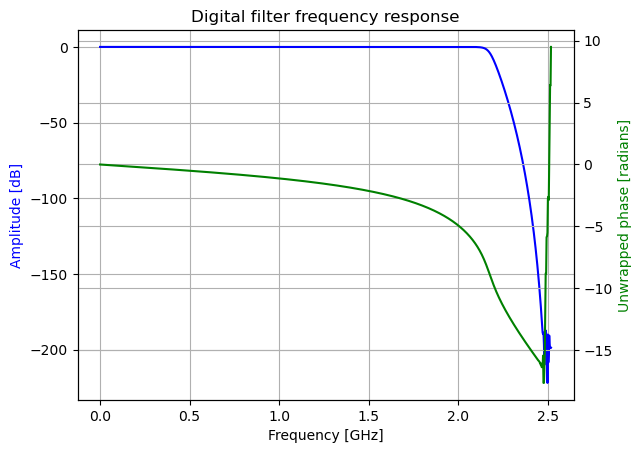

In [6]:
use_zero_phase_filtering = False
use_iir_filtering = True

filtered_upconverted_signal = upconverted_signal
fcutoff_rf = None
a = None
b = None
if use_zero_phase_filtering or use_iir_filtering:
    fcutoff_rf = 5 * fs_bb + fc

if use_zero_phase_filtering:
    numtaps = 101
    b, a = firwin(numtaps, fcutoff_rf, fs = fs), 1.0
    filtered_upconverted_signal = filtfilt(b, a, upconverted_signal)
elif use_iir_filtering:
    order = 11
    b, a = butter(order, fcutoff_rf, fs = fs)
    filtered_upconverted_signal = lfilter(b, a, upconverted_signal)

if use_zero_phase_filtering or use_iir_filtering:
    w, h = freqz(b, a, worN = 1024)
    freqs = (0.5 * fs * w / np.pi) / 1e9
    fig, ax1 = plt.subplots()
    ax1.grid()
    ax1.set_title("Digital filter frequency response")
    ax1.plot(freqs, 20 * np.log10(abs(h)), "b")
    ax1.set_ylabel("Amplitude [dB]", color = "b")
    ax1.set_xlabel("Frequency [GHz]")
    ax2 = ax1.twinx()
    ax2.grid()
    angles = np.unwrap(np.angle(h))
    ax2.plot(freqs, angles, "g")
    ax2.set_ylabel("Unwrapped phase [radians]", color = "g")
    ax2.axis("tight")
    plt.show()

Continue with IQ downsampling as before

In [7]:
downconverted_signal_i = filtered_upconverted_signal * np.cos(2 * np.pi * fc * t)
downconverted_signal_q = -filtered_upconverted_signal * np.sin(2 * np.pi * fc * t)
fcutoff_bb = 10 * fs_bb
numtaps = 33
coeffs = firwin(numtaps, fcutoff_bb, fs = fs)
downconverted_signal_i = filtfilt(coeffs, np.sqrt(0.5), downconverted_signal_i)
downconverted_signal_q = filtfilt(coeffs, np.sqrt(0.5), downconverted_signal_q)
downconverted_signal = downconverted_signal_i + 1.0j * downconverted_signal_q
downsampled_signal = resample(downconverted_signal, len(ofdm))

Re-generate modulation symbols

Regenerated EVM = 110.03%


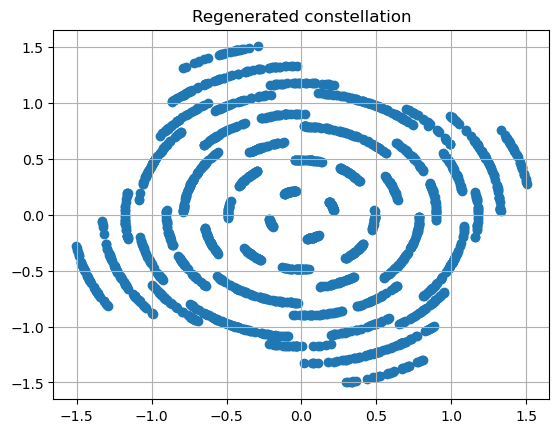

In [8]:
regenerated_symbols = np.fft.fft(downsampled_signal)
'''scaling_factor = np.sqrt(np.mean(np.abs(regenerated_symbols) ** 2 / np.abs(golden_symbols) ** 2))
print(f"scaling_factor = {scaling_factor:.2f}")'''
regenerated_evm = calculate_evm(symbols, regenerated_symbols)
print(f"Regenerated EVM = {regenerated_evm:.2f}%")
plt.figure()
plt.grid()
plt.scatter(np.real(regenerated_symbols), np.imag(regenerated_symbols))
plt.title("Regenerated constellation")
plt.show()

All copyright reserved @2025 Ericsson